<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #8: Agrupación de textos
`Fecha de entrega: Abril 29, 2021. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [168]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [169]:
# Cargar datos
data = 'C:/Users/KeylanRolandoValenci/Documents/Varios Keylan/Clases Especialización/Clases Especialización/Semestre II/NLP/lang_clase.csv' 
df = pd.read_csv(data)
df.head()

,Text
0,a cada etapa do circuito brasileiro banco do b...
1,мини-бар — небольшой холодильник с напитками п...
2,ломоносов м в «письмо и и шувалову от года» ...
3,en les cultivateurs du village se cotisèrent ...
4,en el momento de la compra la tarjeta se entre...


###  `[10 pts]` Punto 1: Hacer pre-procesamiento del texto

In [170]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords_sp = stopwords.words('spanish')


def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d]+", " ", texto)
    return texto




In [171]:
tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(df.Text.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names())


###  `[10 pts]` Punto 2: Método del codo para determinar $K$

In [173]:

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


In [174]:
ks  = []
k_inertias = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)
    
    

C:\Users\KeylanRolandoValenci\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



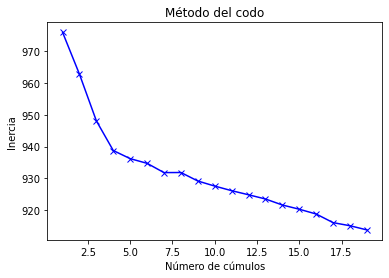

In [175]:
plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-');


###  `[10 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [176]:
k = 4
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

df['cluster'] = model.labels_
df


,Text,cluster
0,a cada etapa do circuito brasileiro banco do b...,1
1,мини-бар — небольшой холодильник с напитками п...,0
2,ломоносов м в «письмо и и шувалову от года» ...,0
3,en les cultivateurs du village se cotisèrent ...,3
4,en el momento de la compra la tarjeta se entre...,2
...,...,...
995,el departamento cuenta con varios canales de t...,2
996,farrington d p b implications of biological fi...,0
997,клевцов в герой несуществующей державы в клев...,0
998,le mars tag heuer annonce à l’occasion du ba...,3


###  `[15 pts]` Punto 4: Interpretación de los clusters

In [155]:


############
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

clust_cnt = df['cluster'].value_counts()
clust_cnt_pct = df['cluster'].value_counts(normalize=True)

centroids = model.cluster_centers_

terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:, ::-1]


In [177]:
for i in range(k):
    print(f"Cluster # {i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    print()
    
    print("TÉRMINOS MÁS REPRESENTATIVOS")
    for ind in order_centroids[i][:20]:
        print(terms[ind], end=" ")
    print()
    print()
    
    print(f"DOCUMENTOS MÁS REPRESENTATIVOS")
    for vecino in df.iloc[nbrs.kneighbors([centroids[i]])[1][0]].Text.values:
        print(f" *** {vecino}")
        print()
        
    print()
    print("********************************************")
    print()

Cluster # 0
Tiene 283 registros (28.30% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
на года по году для не из был от его что за церкви также ломоносова ломоносов комиссии как он the 

DOCUMENTOS MÁS REPRESENTATIVOS
 *** в  году овчинников окончательно вытеснил из основы «локомотива» хасанби биджиева пропустив всего  мяч в  матчах и как следствие получил приглашение в только что образованную сборную россии на её первый в истории матч на стадионе «локомотив» против сборной мексики однако на поле так и не вышел на последующие матчи сборной в течение года овчинников также вызывался но оставался на скамейке запасных

 *** с октября  года начала действия договора по апрель  года товарооборот между странами увеличился на  экспорт вырос на  импорт — на 

 *** в апреле  года ломоносов за дерзкое поведение при академических распрях между «русской» и «немецкой» партиями был заключён под стражу на  месяцев только  января  года сенат заслушав доклад следственной комиссии постановил «оного адъюнкта 

###  `[BONUS: 3 pts]` Visualización usando PCA

In [178]:
clusters = {0: 'Ruso',
            1: "Español",
            2: 'Francés',
            3: 'Portugués'}

df['nombres_clusters'] = df['cluster'].apply(lambda val: clusters[val])
#df.sample(4)

df_centroids = pd.DataFrame(centroids)
df_centroids['cluster'] = clusters.values()
df_centroids




,0,1,2,3,4,5,6,7,8,9,...,20448,20449,20450,20451,20452,20453,20454,20455,20456,cluster
0,2.380823e-03,5.421011e-20,0.000000e+00,4.065758e-20,8.131516e-20,0.000000e+00,-1.626303e-19,-8.131516e-20,8.131516e-20,2.439455e-19,...,7.519861e-04,-1.084202e-19,1.626303e-19,1.626303e-19,-1.355253e-19,-1.084202e-19,2.710505e-20,2.168404e-19,2.168404e-19,Ruso
1,5.709472e-04,1.355253e-20,-5.421011e-20,2.710505e-20,6.776264e-20,9.099553e-04,-1.626303e-19,-9.486769e-20,1.355253e-20,2.439455e-19,...,1.355253e-19,0.000000e+00,7.900961e-04,7.900961e-04,6.513262e-04,-8.131516e-20,0.000000e+00,1.626303e-19,1.626303e-19,Español
2,-1.084202e-18,2.710505e-20,-2.710505e-20,3.425556e-04,8.131516e-20,-8.131516e-20,4.967552e-04,-9.486769e-20,3.275704e-04,7.868505e-04,...,1.897354e-19,5.013938e-04,1.626303e-19,1.626303e-19,-1.626303e-19,-1.084202e-19,8.904195e-04,5.063861e-04,5.063861e-04,Francés
3,-7.589415e-19,4.015270e-04,2.555090e-04,4.065758e-20,2.729548e-04,-5.421011e-20,-1.626303e-19,4.454947e-04,4.065758e-20,2.439455e-19,...,1.897354e-19,-2.710505e-20,1.626303e-19,1.626303e-19,-1.355253e-19,5.559149e-04,0.000000e+00,1.897354e-19,1.897354e-19,Portugués


In [179]:
! pip install plotly
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.offline import iplot

In [180]:
#El argumento n_components determina el número de componentes calculados. Si se indica None, se calculan todas las posibles (min(filas, columnas) - 1)
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = df.nombres_clusters.values
result['texto'] = df.Text.apply(lambda val: val[:140])

colorsIdx = {'Ruso': 'blue',
             'Español': 'yellow',
             'Portugués': 'green',
             'Francés': 'red'}

result['colores'] = result['cluster'].map(colorsIdx)


result.head()


trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['colores'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

nuevo = ["El vecino de la profesora puso música esta tarde", 
         "Bom dia pessoal, o Brasil é o melhor pais do mundo",
         "La serie Game of Thrones ganó en los TV Awards of Los Angeles",
         "Bom dia meus caros amigos, buenos días mis queridos amigos"]
nuevo_trans = tfidf_vect.transform(nuevo)
[clusters[i] for i in model.predict(nuevo_trans)]

['Francés', 'Español', 'Francés', 'Ruso']

# Comparación

### `[BONUS 20 pts (validos para cualquier tarea)]` 
### Hacer predicción para estas dos frases de los dos modelos (clasificación y $k$-means)

In [181]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]

In [183]:
nuevo_trans_bonus = tfidf_vect.transform(test)
[clusters[i] for i in model.predict(nuevo_trans_bonus)]

['Francés', 'Ruso']

### `[5 pts]` Punto 5: Preguntas

- Según los resultados del $K$-Means, ¿cuál es la estructura de los datos?
##### Rta/  
Entiendo que la estructura de los datos según K-means se basa en clasificar la data que hay de acuerdo a una característica específica que el modelo determina como patrón para efectuar su agrupamiento, para este caso, el idioma del texto.


- ¿Qué diferencia notó entre los resultados del taller pasado y este?
##### Rta/  
Considero que estos datos pueden llegar a ser mas precisos con este modelo si tuviésemos mas categorías para clasificar el texto.

- ¿Alguna otra observación?
##### Rta/
No entiendo porqué la predicción con las variables alojadas en Test, no funcionaron.